Reffered link:

https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

https://www.kaggle.com/bonhart/brain-mri-data-visualization-unet-fpn/notebook

https://www.kaggle.com/monkira/brain-mri-segmentation-using-unet-keras

https://www.kaggle.com/sameerpabbaraja/brain-mri-segmentation-dropout-0-3

https://www.kaggle.com/lqdisme/brain-mri-segmentation-unet-keras

---



Introduction:

1. Business Problem:

i) Description:

Biomedical Imaging like X-rays, CT scans, MRI assists the doctor in the evaluation
of the patient’s current condition.A Brain Tumor is a cluster of abnormal cells grown out of
control in the brain. In medical terms, it is called a glioma.For the diagnosis to be done
properly, proper identification of tumor in the brain is needed, MRI scans are taken from
patients, and identification of tumor in it is conventionally done by expert radiologists.

Early tumor detection in the brain will save many lives. Due to the varying shape and sizes
of tumors, it’s hard to locate the exact location. A considerable amount of time is required
to detect and locate the tumor in MRI.

Automating this process will add efficiency to the system and free medical staff
time which can be utilized to serve more patients. It eliminates the human errors which
are more common in developing nations due to the shortage of trained medical staff.

ii) Problem statement:

To segment tumors from normal tissues in the MRI image of the brain.

===================================================================================================================

2.Data Overview

i)Taken data from Brain MRI segmentation challenge on kaggle.

https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

ii)Dataset consists of 110 patients MRI(Magnetic resonance imaging) together with manual
FLAIR (Fluid-attenuated inversion recovery) abnormality segmentation masks obtained from The
Cancer Imaging Archive (TCIA).

iii)data.csv file contains patient data and Tumor genomic clusters. MRI scans are in 110
folders named after the CASE_ID. Each folder contains MR images with the following naming
convention:
TCGA_<institution-code>_<patient-id>_<slice-number>.tif
Corresponding masks have a ” _mask” suffix. Images are in .tif format having three channels per
image.

What is image segmentation?

It is the process of classifying each pixel belonging to a particular class.
Here for this task, we will have two classes :
● tumor part
● non-tumor part

===================================================================================================================

3. Mapping the real world problem to an ML problem:

i) Business objective:

● To create segmentation masks for tumors in the human brain using MRI scans.

● Using the segmentation masks we can determine whether the tumor is present or not.

ii )Performance Metric:

Dice Coefficient.

Dice coefficient can also be interpreted as loss function:

Dice Loss(y,y_pred)=1-[((2*y*y_pred)+1)/(y+y_pred+1)]

Range of dice loss function is 0 to 1

y=ground truth label

y_pred=predicted label

===================================================================================================================

In [4]:
!pip install kaggle
from google.colab import files
from datetime import datetime
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
#!kaggle competitions download mateuszbuda/lgg-mri-segmentation
#https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation
!kaggle datasets download mateuszbuda/lgg-mri-segmentation 

 99% 707M/714M [00:18<00:00, 28.3MB/s]
100% 714M/714M [00:18<00:00, 39.7MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip
'''
 inflating: lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_63.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_63_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_64.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_64_mask.tif 
  TCGA_<institution-code>_<patient-id>_<slice-number>.tif
        |
  TCGA_HT_A61B_19991127_64_mask.tif
'''

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import seaborn as sns
os.listdir()

['.config',
 'adc.json',
 'kaggle_3m',
 'drive',
 'lgg-mri-segmentation',
 'lgg-mri-segmentation.zip',
 'kaggle.json',
 'sample_data']

In [ ]:
df = pd.read_csv("/content/lgg-mri-segmentation/kaggle_3m/data.csv")

In [ ]:
df.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [ ]:
df.shape

(110, 18)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [ ]:
#you may wish to determine how many missing values exist in the collection, in which case you can use .sum()
df.isnull().sum()

Patient                       0
RNASeqCluster                18
MethylationCluster            1
miRNACluster                  0
CNCluster                     2
RPPACluster                  12
OncosignCluster               5
COCCluster                    0
histological_type             1
neoplasm_histologic_grade     1
tumor_tissue_site             1
laterality                    1
tumor_location                1
gender                        1
age_at_initial_pathologic     1
race                          2
ethnicity                     8
death01                       1
dtype: int64

OBSERVATION:

df.info () & df.isnull().sum() tells that we have null values in all columns except for columns "Patient" , "miRNACluster" and "COCCluster".

In [ ]:
df.gender.value_counts()

1.0    56
2.0    53
Name: gender, dtype: int64

OBSERVATION:

The above shows that gender is equally represented in the given dataset.That is equal datapoints given for both gender.

In [ ]:
!ls

kaggle_3m    lgg-mri-segmentation      sample_data
kaggle.json  lgg-mri-segmentation.zip


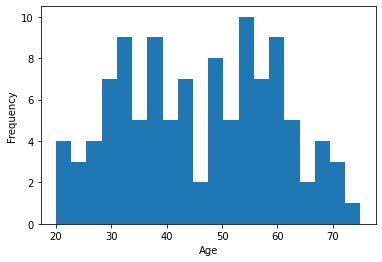

In [ ]:
df["age_at_initial_pathologic"].plot(kind="hist",bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

OBSERVATION:

age_at_initial_pathologic -> Patient age in years

The above histogram shows that patient whose age between 54 to 57 appears more number of times in the given dataset.

In [ ]:
df["tumor_location"].value_counts()

2.0    63
6.0    32
5.0    12
1.0     1
4.0     1
Name: tumor_location, dtype: int64

In [ ]:
df["death01"].value_counts()

0.0    82
1.0    27
Name: death01, dtype: int64

In [ ]:
#
df["ethnicity"].value_counts()

2.0    99
1.0     3
Name: ethnicity, dtype: int64

In [ ]:
df["race"].value_counts()

3.0    98
2.0    10
Name: race, dtype: int64

In [ ]:
df["Patient"].nunique()

110

OBSERVATION:

There are 110 unique patient details given. And most of the data's that given in our dataset is only categorical data and also it is not a imbalanced data as the data's are equally given for both the gender.Hence we can proceed now with getting images & thier mask from  data folder-->"kaggle_3m" in order to proceed with deep learning modelling.

And also there are some missing values  in all columns except for columns "Patient" , "miRNACluster" and "COCCluster". But here we are mainly going to focus on images and their corresponsding mask to train our DL model. Hence we can ignore those missing values. We should concentrate only on whether we have maked images for all given image since we are going to use images to train our DL model

In [ ]:
#PATH will have the path of the images and thier corresponding mask images
PATH = "/content/lgg-mri-segmentation/kaggle_3m"
list_dir = []
for dir in os.listdir(PATH):
    #TCGA_<institution-code>_<patient-id>_<slice-number>.tif
    #print("dir:",dir) #dir: TCGA_DU_5853_19950823
    dir = PATH + '/' + dir
    #print("dir:",dir) #dir: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325
    if os.path.isdir(dir):
        #list_dir will have the path of MRI images and mask of all the 110 patient
        list_dir.append(dir)

In [ ]:
list_dir[:5]

['/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8114_19981030',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111',
 '/content/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903']

In [ ]:
k=0
for i in os.listdir('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614'):
  if '_mask' in i:
    #print("chek")
    if k<=3:
      print(i)
      k+=1

TCGA_DU_A5TP_19970614_20_mask.tif
TCGA_DU_A5TP_19970614_32_mask.tif
TCGA_DU_A5TP_19970614_18_mask.tif
TCGA_DU_A5TP_19970614_38_mask.tif


In [ ]:
k=0
for i in os.listdir('/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614'):
  if '_mask' not in i:
    #print("chek")
    if k<=3:
      print(i)
      k+=1

TCGA_DU_A5TP_19970614_12.tif
TCGA_DU_A5TP_19970614_14.tif
TCGA_DU_A5TP_19970614_33.tif
TCGA_DU_A5TP_19970614_24.tif


In [ ]:
os.listdir('kaggle_3m')[0:10]

['TCGA_DU_A5TP_19970614',
 'TCGA_HT_8114_19981030',
 'TCGA_DU_5871_19941206',
 'TCGA_DU_8164_19970111',
 'TCGA_FG_A4MU_20030903',
 'TCGA_HT_7882_19970125',
 'TCGA_DU_7014_19860618',
 'TCGA_FG_6691_20020405',
 'TCGA_HT_7884_19980913',
 'TCGA_DU_A5TR_19970726']

In [ ]:
def return_file_names_df(list_dir):
  image=[]
  mask=[]
  for i in range(len(list_dir)):
    dir_path=list_dir[i]
    #print("dir:",dir) #dir: /content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325
    for tif_file in os.listdir(dir_path):
      #print("tif_file:",tif_file)
      #tif_file: TCGA_DU_8168_19970503_28.tif
      #tif_file: TCGA_DU_8168_19970503_28_mask.tif
      if '_mask' in tif_file:
        mask.append(dir_path+'/'+tif_file)
        tif_file = tif_file.replace('_mask','')
        image.append(dir_path+'/'+tif_file)
  data_df = pd.DataFrame(list(zip(image, mask)), columns = ['images', 'mask'])
  return data_df,image,mask

In [ ]:
data_df,images,mask = return_file_names_df(list_dir)
data_df.head()
#return_file_names_df(list_dir)

,images,mask
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...


In [ ]:
print(data_df['images'][0])
print(data_df['mask'][0])

/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_20.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_20_mask.tif


In [ ]:
data_df.isnull().sum()

images    0
mask      0
dtype: int64

In [ ]:
print(len(data_df['images']))
print(len(data_df['mask']))

3929
3929


OBSERVATION:

The above shows that the given datasets has both images(3929 file) and the corresponding mask(3929 file).

In [ ]:
#checking whether all the files in the images and mask are proper files or not
for file in images:
  if not os.path.isfile(file):
    print("error")

In [ ]:
#checking whether all the files in the images and mask are proper files or not
for file in mask:
  if not os.path.isfile(file):
    print("error")

OBSERVATION:

The above shows that all the images are proper files.

DATA VISUALIZATION:

(256, 256, 3)


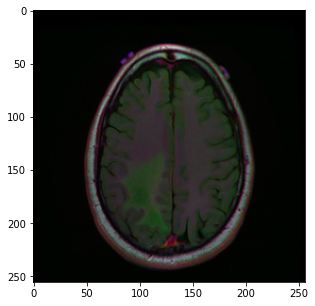

In [67]:
#referred this link -- https://www.mathworks.com/help/matlab/ref/imread.html
image1=data_df['images'][20]
img=cv2.imread(image1)
print(img.shape)
plt.figure(figsize=(7, 5))
plt.imshow(img)

(256, 256, 3)


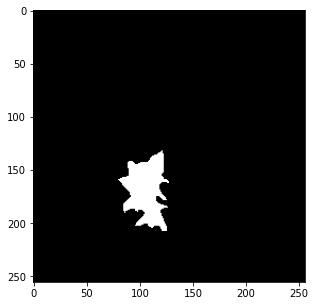

In [66]:
#referred this link -- https://www.mathworks.com/help/matlab/ref/imread.html
mask1=data_df['mask'][20]
m=cv2.imread(mask1)
print(m.shape)
plt.figure(figsize=(7, 5))
plt.imshow(m)

In [ ]:
print(np.max(m))
print(np.min(m))

255
0


OBSERVATION:

The above plot of **MRI mask image** which has "tumor" shows that the **affected area (that is tumor area) has pixel with high resolution**. So we can use **np.max** to know whether the **MRI mask image** has **tumor or not**. So one more column can be added in our dataframe "**tumor_or_not**" to differentiate **MRI mask images "with tumor" and "without tumor"**.

And also the shape of both image & mask is (256,256,3)

In [ ]:
def find_tumor_in_mask_image(MRI_mask_image):
  #Finding whether MRI mask image has tumor or not
  masked_img=cv2.imread(MRI_mask_image)
  m_img=np.max(masked_img)
  if m_img>0:
    #mask images has tumor (pixel > 0 --> white area in the image)
    return 1
  else:
    #mask images has no tumor (pixel =0 --> black area in the image)
    return 0

In [ ]:
data_df["tumor_or_not"] = data_df['mask'].apply(find_tumor_in_mask_image)

In [ ]:
data_df.head()

,images,mask,tumor_or_not
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0


In [68]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   images        3929 non-null   object
 1   mask          3929 non-null   object
 2   tumor_or_not  3929 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.2+ KB


In [ ]:
#data_df.to_csv('/content/drive/My Drive/Colab Notebooks/final_cs2.csv', index=False)

In [10]:
import pandas as pd
data_df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_cs2.csv')

In [11]:
data_df.head(10)

,images,mask,tumor_or_not
0,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
2,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
4,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
5,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
6,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
7,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
8,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
9,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0


In [12]:
print(data_df['images'][0])
print(data_df['mask'][0])

/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_20.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_20_mask.tif


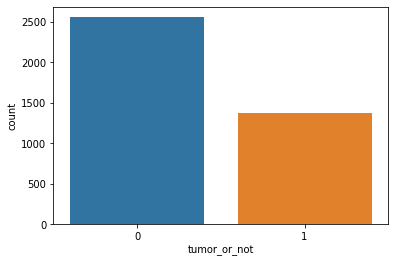

In [32]:
#https://www.geeksforgeeks.org/seaborn-categorical-plots/
sns.countplot(x ='tumor_or_not', data = data_df)

patch: Rectangle(xy=(-0.25, 0), width=0.5, height=2556, angle=0)
patch: Rectangle(xy=(0.75, 0), width=0.5, height=1373, angle=0)


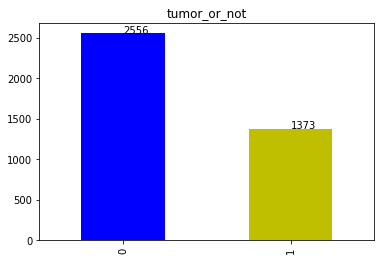

In [36]:
ax = data_df["tumor_or_not"].value_counts().plot(kind = "bar",title = "tumor_or_not",color=['b','y'] )
for patch in ax.patches:
    print("patch:",patch)
    #print("x1:",patch.get_x())
    #print("h1:",patch.get_height())
    ax.annotate(xy = (patch.get_x() + 0.25 ,patch.get_height()+0.5 ),s = str(patch.get_height()) )

OBSERVATION:

The above plot shows that **2556 of patients have "no tumor"** and **1373 of patients have "tumor"**

Hence we can create a **classification model** to find out whether a **patients have "tumor" or "no tumor".**

In [43]:
no_tumor=data_df[data_df['tumor_or_not']==0].sample(5)
tumor=data_df[data_df['tumor_or_not']==1].sample(5)

In [48]:
no_tumor[:2]

,images,mask,tumor_or_not
3668,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_H...,0
3077,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0


In [47]:
tumor[:2]

,images,mask,tumor_or_not
3919,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1
1263,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,/content/lgg-mri-segmentation/kaggle_3m/TCGA_C...,1


In [59]:
def plot_image_mask(image,mask):
  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(8,6))
  ax[0].imshow(image)
  ax[0].set_title("image",fontsize=10)
  ax[1].imshow(mask)
  ax[1].set_title("mask",fontsize=10)

In [62]:
def plot_image_mask1(image,mask):
  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(8,6))
  ax[0].imshow(image)
  ax[0].set_title("image",fontsize=10)
  ax[1].imshow(mask)
  ax[1].set_title("mask",fontsize=10)

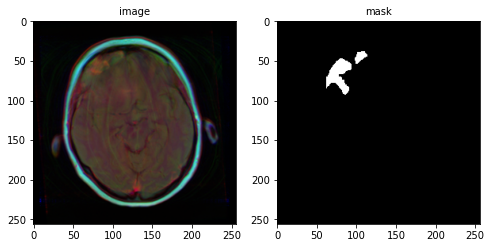

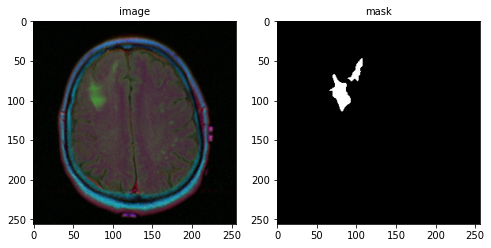

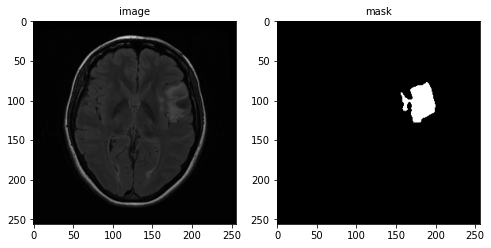

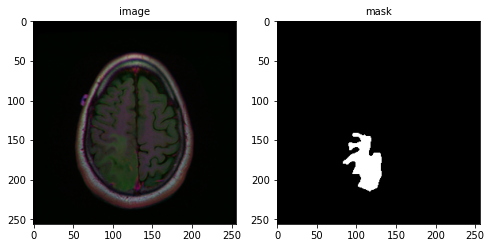

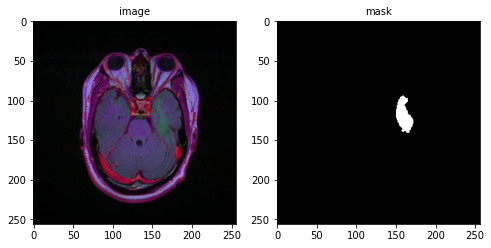

In [60]:
for i in tumor.index:
  image=cv2.imread(tumor.loc[i]['images'])
  mask=cv2.imread(tumor.loc[i]['mask'])
  plot_image_mask(image,mask)

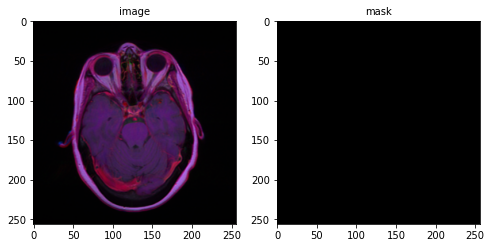

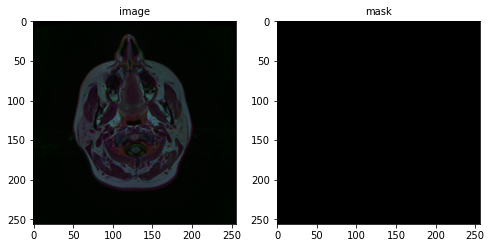

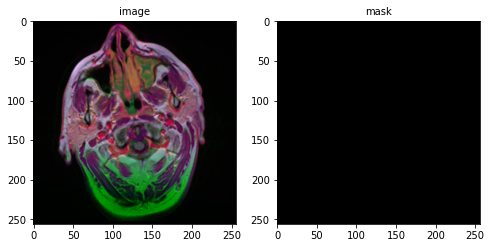

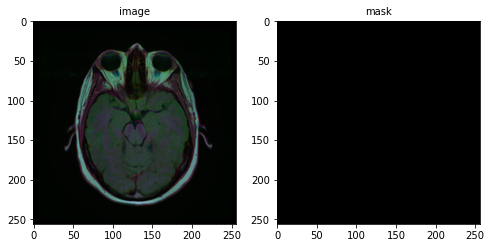

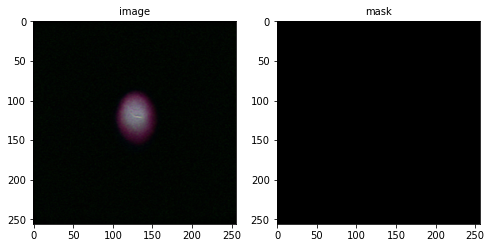

In [61]:
for i in no_tumor.index:
  image=cv2.imread(no_tumor.loc[i]['images'])
  mask=cv2.imread(no_tumor.loc[i]['mask'])
  plot_image_mask(image,mask)

OBSERVATION:

The above plot shows that size of tumor in MRI masked image is varying.

And also MRI scan image of brain is not in same size. some MRI scan image of brain is bigger and some smaller in size.